In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


# Intro
* lable == 1: unreliable
* label == 0: reliable

In [2]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_df = pd.read_csv('/kaggle/input/fake-news/train.csv')
test_df = pd.read_csv('/kaggle/input/fake-news/test.csv')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
train_df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [7]:
print("[title] ",train_df['title'][0])
print("[title] ",train_dfdf['text'][0])

[title]  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It


NameError: name 'train_dfdf' is not defined

# EDA
* Label Percent
* Text length / Word length per Label Percent

In [8]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


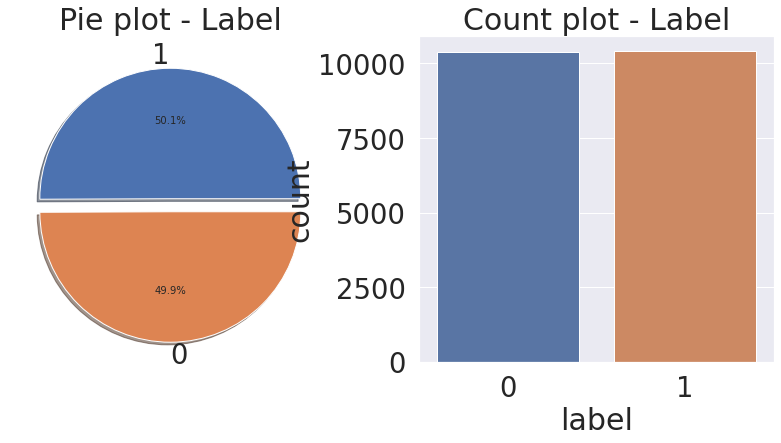

In [9]:
f,ax = plt.subplots(1,2,figsize=(14,6))
train_df['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = train_df, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

In [10]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [11]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [12]:
train_df['length_alphabets'] = train_df['text'].apply(get_length_alphabets)
train_df['length_words'] = train_df['text'].apply(get_length_words)

In [13]:
train_df.head()

,id,title,author,text,label,length_alphabets,length_words
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154


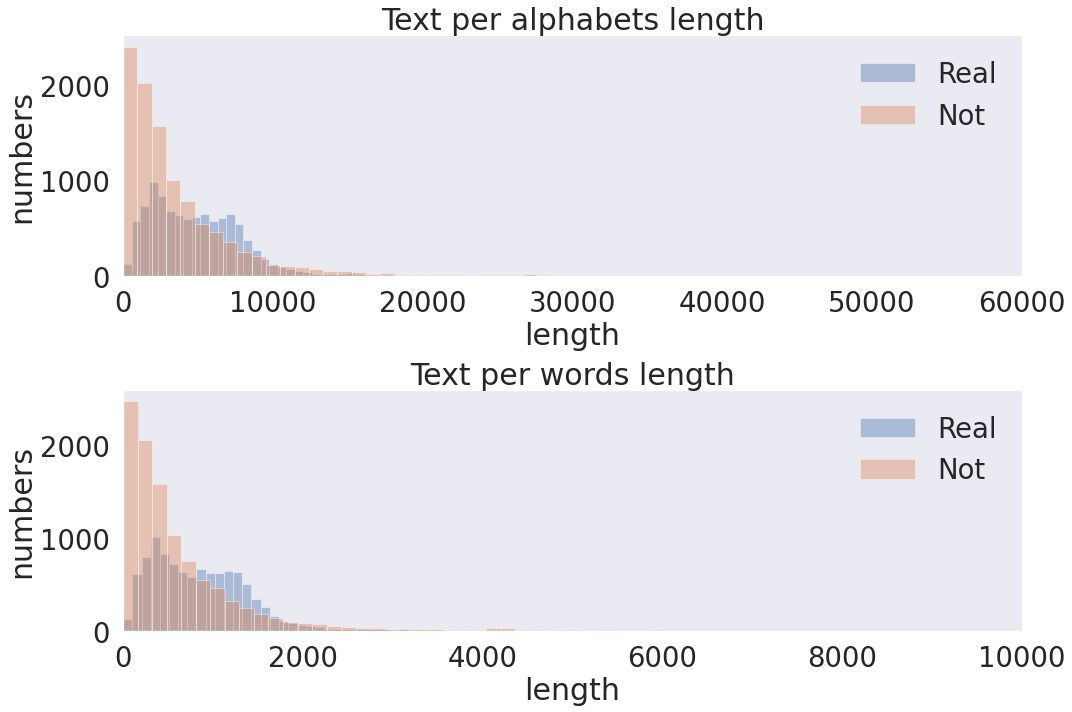

In [14]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Text per alphabets length')
ax[0].hist(train_df[train_df['label'] == 0]['length_alphabets'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(train_df[train_df['label'] == 1]['length_alphabets'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,60000)
ax[0].grid()

ax[1].set_title('Text per words length')
ax[1].hist(train_df[train_df['label'] == 0]['length_words'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(train_df[train_df['label'] == 1]['length_words'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,10000)
ax[1].grid()

f.tight_layout()
plt.show()

# Preprocessing
* Null Value Processing
* Drop Columns

In [15]:
train_df[train_df['author'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2729,489
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177,1452
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,2231,377
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,2801,486
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,7050,1146


In [16]:
train_df['author'] = train_df['author'].fillna('unknow')
test_df['author'] = test_df['author'].fillna('unknow')

In [17]:
train_df[train_df['title'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,679,131
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,135,16
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,533,100
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,736,120
196,196,NaN,Raffie,They got the heater turned up on high.,1,38,8


In [18]:
# Get average title size
train_df['title_size'] = train_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
title_size_3_index = train_df[train_df['title_size']==3].index
train_df['title_size'][title_size_3_index] = 0 

train_avg_title_size = int(train_df.value_counts(['title_size']).mean())
print("train avg_title_size: ",train_avg_title_size)

train avg_title_size:  98


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# Get average title size
test_df['title_size'] = test_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
title_size_3_index = test_df[test_df['title_size']==3].index
test_df['title_size'][title_size_3_index] = 0 

test_avg_title_size = int(test_df.value_counts(['title_size']).mean())
print("test avg_title_size: ",test_avg_title_size)

test avg_title_size:  33


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#change title "NAN" to text[:98]
train_nan_index = train_df['title'].isnull().index
train_df['title'][train_nan_index] = train_df['text'][train_nan_index].apply(lambda x: str(x)[:train_avg_title_size])

test_nan_index = test_df['title'].isnull().index
test_df['title'][test_nan_index] = test_df['text'][test_nan_index].apply(lambda x: str(x)[:test_avg_title_size])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
train_df[train_df['text'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words,title_size
142,142,nan,unknow,NaN,1,3,1,106
573,573,nan,unknow,NaN,1,3,1,76
1200,1200,nan,unknow,NaN,1,3,1,103
1911,1911,nan,unknow,NaN,1,3,1,109
2148,2148,nan,unknow,NaN,1,3,1,123


In [22]:
train_df.dropna(subset=['text'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)

In [23]:
train_df.isnull().sum()

id                  0
title               0
author              0
text                0
label               0
length_alphabets    0
length_words        0
title_size          0
dtype: int64

In [24]:
train_df.drop(['length_alphabets','length_words','title_size'], axis=1, inplace = True)
test_df.drop(['title_size'], axis=1, inplace = True)

In [25]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,Ever get the feeling your life circles the rou...,Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Feature Engineering
* Nomalization
* Plot WordClouds
* Words Tokenization

In [26]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [27]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [28]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

#### WordCloud
* Label == 0 Real News
* Label == 1 Fake News

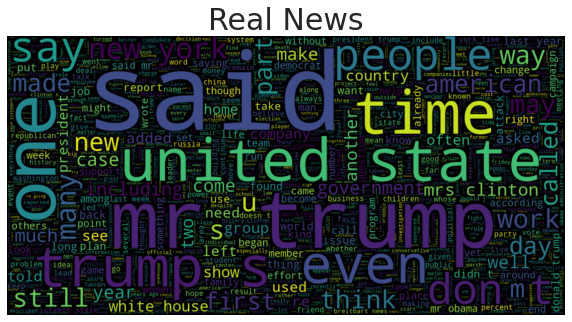

In [29]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 0].text))
plt.axis('off')
plt.title('Real News')
plt.imshow(wc,interpolation = 'bilinear')

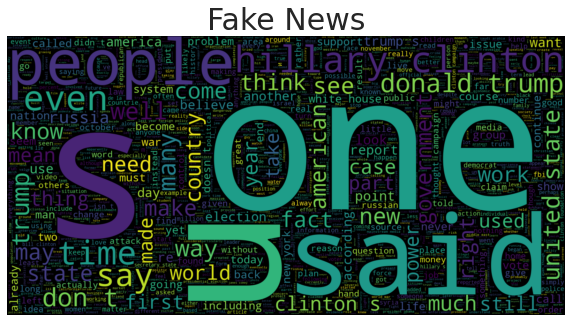

In [30]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 1].text))
plt.axis('off')
plt.title('Fake News')
plt.imshow(wc,interpolation = 'bilinear')

In [31]:
tokenizer = Tokenizer(
    num_words = 10000,
    lower = True
)
tokenizer.fit_on_texts(train_df['text'])

In [32]:
x_train = pad_sequences(
    tokenizer.texts_to_sequences(train_df['text']),
    maxlen = 2000)

x_test = pad_sequences(
    tokenizer.texts_to_sequences(test_df['text']),
    maxlen = 2000)

In [33]:
print("First Train data squence info : ", x_train[0].shape)
print(x_train[0])

First Train data squence info :  (2000,)
[   0    0    0 ... 1605  957 4093]


# Modeling